In [1]:
import ast
import glob
import json
import math
import numpy as np
import os
import pandas as pd
import random
import time
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import transforms
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [2]:
data_path = 'CCPD2019'
print("Path to dataset files:", data_path)

Path to dataset files: CCPD2019


In [ ]:
# Definizione della classe PlateTransform per preprocessing

class PlateTransform:
    def __init__(self, size=(48, 144), crop_plate=True):
        self.size = size
        self.crop_plate = crop_plate

        self.transform = transforms.Compose([
            transforms.Resize(self.size, interpolation=Image.BILINEAR),
            transforms.ToTensor(),
        ])

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        bbox = sample.get('bbox', None) 

        if self.crop_plate and bbox:
            x1, y1, x2, y2 = bbox
            image = image.crop((x1, y1, x2, y2))

        image = self.transform(image)

        return {'image': image, 'label': label}


In [ ]:
# Funzione per decodificare l'encoded label della targa

# Liste delle provinces, alphabets, and ads (numbers + letters)
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

def decode_license_plate(encoded_label):   
    province = provinces[encoded_label[0]]
    alphabet = alphabets[encoded_label[1]]
    ad1 = ads[encoded_label[2]]
    ad2 = ads[encoded_label[3]]
    ad3 = ads[encoded_label[4]]
    ad4 = ads[encoded_label[5]]
    ad5 = ads[encoded_label[6]]

    license_plate = province + alphabet + ad1 + ad2 + ad3 + ad4 + ad5
    return license_plate


In [ ]:
# Funzione per visualizzare un campione di targa con la sua bounding box e label

def plot_plate_sample(csv_row, base_path, transformer=None, title_prefix=""):
    img_rel_path = csv_row['image_path']
    encoded_label = ast.literal_eval(csv_row['encoded_label'])  # [index1, index2, ..., index7]
    bbox = ast.literal_eval(csv_row['bbox'])          # [x1, y1, x2, y2]

    license_plate = decode_license_plate(encoded_label)

    img_path = os.path.join(base_path, img_rel_path)
    image = Image.open(img_path).convert("RGB")

    transformed_img = None
    if transformer:
        transformed = transformer({
            'image': image,
            'label': license_plate, 
            'bbox': bbox
        })
        transformed_img = transformed['image'].permute(1, 2, 0).numpy()  

    fig, axes = plt.subplots(1, 2 if transformer else 1, figsize=(12, 5))

    font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # For displaying text in Chinese
    font_prop = fm.FontProperties(fname=font_path)

    try:
        font = ImageFont.truetype(font_path, 35) 
    except IOError:
        font = ImageFont.load_default()

    # Bounding box sull'immagine originale
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline="red", width=2)
    
    # Label sopra la bounding box
    label_x = bbox[0] 
    label_y = bbox[1] - 40 

    draw.text((label_x, label_y), license_plate, font=font, fill="red") 

    axes[0].imshow(image)
    axes[0].set_title(f"{title_prefix} Original")

    if transformer:
        axes[1].imshow(transformed_img)
        axes[1].set_title(f"{title_prefix} Transformed (cropped + resized)")

    plt.tight_layout()
    plt.show()


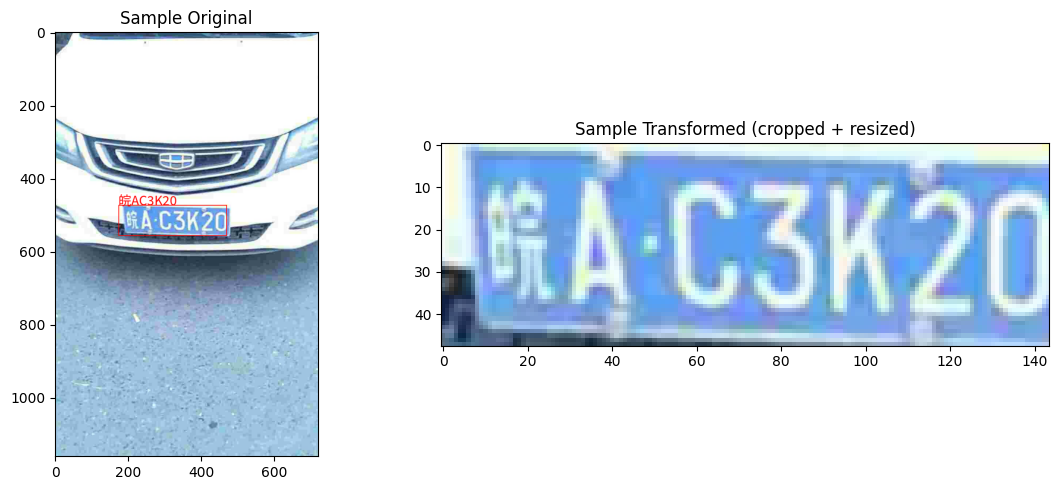

In [6]:
# CSV
df = pd.read_csv("train.csv")
row = df.iloc[2] 

# Transformation
transformer = PlateTransform(size=(48, 144), crop_plate=True)

plot_plate_sample(row, data_path, transformer=transformer, title_prefix="Sample")


In [7]:
def apply_plate_augmentation(sample, aug_prob=0.5):

    image = sample['image']

    # Color Jitter
    if random.random() < aug_prob:
        color_jitter = transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        )
        image = color_jitter(image)

    # Random noise
    if random.random() < aug_prob:
        noise_std = 0.01 
        noise = torch.randn_like(image) * noise_std
        image = torch.clamp(image + noise, 0.0, 1.0)

    return {'image': image}


In [ ]:
# Funzione per visualizzare un'immagine di targa con la sua bounding box e trasformazioni

def plot_plate_triple(csv_row, base_path, transformer=None, augment=False, title_prefix=""):

    img_rel_path = csv_row['image_path']
    encoded_label = ast.literal_eval(csv_row['encoded_label'])  # [index1, index2, ..., index7]
    bbox = ast.literal_eval(csv_row['bbox'])          # [x1, y1, x2, y2]

    license_plate = decode_license_plate(encoded_label)

    img_path = os.path.join(base_path, img_rel_path)
    original_image = Image.open(img_path).convert("RGB")

    orig_display = original_image.copy()
    draw = ImageDraw.Draw(orig_display)
    draw.rectangle(bbox, outline="red", width=2)

    # Font con caratteri cinesi
    font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # Path
    try:
        font = ImageFont.truetype(font_path, 35) 
    except IOError:
        font = ImageFont.load_default()

    label_x = bbox[0] 
    label_y = bbox[1] - 40 

    draw.text((label_x, label_y), license_plate, font=font, fill="red") 

    # Immagine trasformata (crop + resize)
    transformed_img = None
    if transformer:
        transformed = transformer({
            'image': original_image.copy(),
            'label': license_plate, 
            'bbox': bbox
        })
        transformed_img = transformed['image'].permute(1, 2, 0).numpy()

    # Augmentation (jitter, noise, blur)
    augmented_img = None
    if augment and transformed:
        augmented = apply_plate_augmentation(transformed, aug_prob=1.0)
        augmented_img = augmented['image'].permute(1, 2, 0).numpy()

    # Plot
    n_cols = 3 if augment else 2
    fig, axes = plt.subplots(1, n_cols, figsize=(15, 5))
    if title_prefix:
        fig.suptitle(title_prefix, weight="bold")

    # Immagine originale
    axes[0].imshow(orig_display)
    axes[0].set_title("Original + BBox")

    # Immagine trasformata
    axes[1].imshow(transformed_img)
    axes[1].set_title("Transformed (crop + resize)")

    if augment:
        axes[2].imshow(augmented_img)
        axes[2].set_title("Augmented (jitter + noise)")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


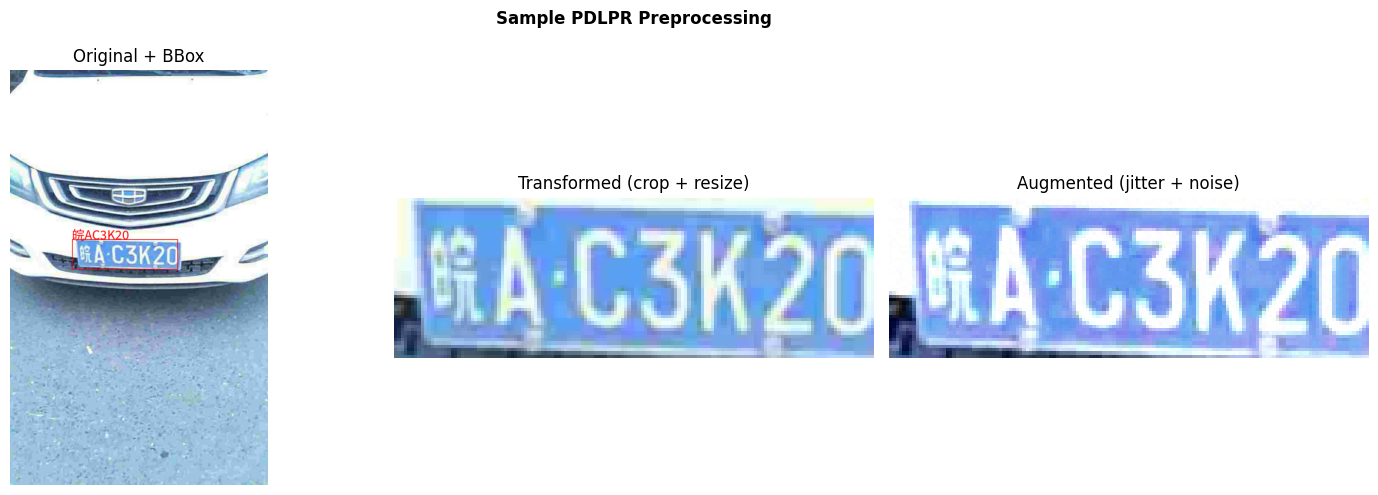

In [ ]:
# Caricamento del CSV di cui si vuole visualizzare un campione
df = pd.read_csv("train.csv")
row = df.iloc[2]

# Trasformazione con crop + resize
transformer = PlateTransform(size=(48, 144), crop_plate=True)

plot_plate_triple(row, data_path, transformer=transformer, augment=True, title_prefix="Sample PDLPR Preprocessing")


In [ ]:
# Dataset customizzato per CCPD2019

class CCPDPlateDataset(Dataset):
    def __init__(self, csv_file, base_dir, transform=None, augment=False, aug_prob=0.5, mode='train'):

        self.csv_file = csv_file
        self.base_dir = base_dir
        self.transform = transform
        self.augment = augment and mode == 'train'
        self.aug_prob = aug_prob

        try:
            df = pd.read_csv(csv_file)

            if df.shape[1] == 1 and df.columns[0].startswith("image_path"):
                df = pd.read_csv(csv_file, sep=',', engine='python')

            df['image_path'] = df['image_path'].astype(str)
            df['annotation'] = df['annotation'].astype(str)
            df['encoded_label'] = df['encoded_label'].astype(str)
            df['bbox'] = df['bbox'].apply(ast.literal_eval)

            self.data_info = df

        except Exception as e:
            raise RuntimeError(f"Errore nel caricamento del CSV {csv_file}: {e}")

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        row = self.data_info.iloc[idx]
        image_path = os.path.join(self.base_dir, row['image_path'])

        try:
            label = torch.tensor(ast.literal_eval(row['encoded_label']), dtype=torch.long)
        except Exception as e:
            raise ValueError(f"Errore nella conversione di encoded_label: {row['encoded_label']} - {e}")

        bbox = row['bbox']
        label_str = row['annotation'] 

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Errore nel caricamento immagine: {image_path}")
            raise e

        sample = {
            'image': image,
            'label': label,
            'label_str': label_str,
            'bbox': bbox
        }

        if self.transform:
            sample = self.transform(sample)

        if self.augment:
            aug_result = apply_plate_augmentation(sample, aug_prob=self.aug_prob)
            sample['image'] = aug_result['image']

        return sample


In [11]:
# Training Dataset
train_dataset = CCPDPlateDataset(
    csv_file="train.csv",
    base_dir="CCPD2019",
    transform=PlateTransform(size=(48, 144), crop_plate=True),
    augment=True,
    aug_prob=0.5,
    mode='train'
)

print(f"\n==================== TRAIN DATASET ====================\n")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Augmentation enabled: {train_dataset.augment}")
print(f"Augmentation probability: {train_dataset.aug_prob}")

train_batch_size = 128  # Come nel paper
train_loader = DataLoader(
    train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True, 
    drop_last=True,
    num_workers=6  # Ottimizzato per 8 vCPU (n_cores - 2)
)
print(f"Train DataLoader batch size: {train_batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")
print(f"Number of workers: {train_loader.num_workers}")

# Validation Dataset
val_dataset = CCPDPlateDataset(
    csv_file="val.csv",
    base_dir="CCPD2019",
    transform=PlateTransform(size=(48, 144), crop_plate=True),
    augment=False,
    mode='val'
)

print(f"\n==================== VALIDATION DATASET ===============\n")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Augmentation enabled: {val_dataset.augment}")

val_batch_size = 5
val_loader = DataLoader(
    val_dataset, 
    batch_size=val_batch_size, 
    shuffle=False,
    num_workers=2 
)
print(f"Val DataLoader batch size: {val_batch_size}")
print(f"Number of batches per epoch: {len(val_loader)}")
print(f"Number of workers: {val_loader.num_workers}")

# Test Dataset
test_dataset = CCPDPlateDataset(
    csv_file="test.csv",
    base_dir="CCPD2019",
    transform=PlateTransform(size=(48, 144), crop_plate=True),
    augment=False,
    mode='test'
)

print(f"\n==================== TEST DATASET =====================\n")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Augmentation enabled: {test_dataset.augment}")

test_batch_size = 5
test_loader = DataLoader(
    test_dataset, 
    batch_size=test_batch_size, 
    shuffle=False,
    num_workers=2
)
print(f"Test DataLoader batch size: {test_batch_size}")
print(f"Number of batches per epoch: {len(test_loader)}")
print(f"Number of workers: {test_loader.num_workers}")

# Log primo batch del training
print("\n--- Logging first training batch ---")
for i, sample in enumerate(train_loader):
    if i == 0:
        print(f"Shape of first batch (image): {sample['image'].shape}")
        print(f"Label example (encoded): {sample['label'][0]}")
        
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        break

# Log primo batch della validazione
print("\n--- Logging first validation batch ---")
for i, sample in enumerate(val_loader):
    if i == 0:
        print(f"Shape of first val image: {sample['image'].shape}")
        print(f"Val label (encoded): {sample['label'][0]}")
        break

# Log primo batch del test
print("\n--- Logging first test batch ---")
for i, sample in enumerate(test_loader):
    if i == 0:
        print(f"Shape of first test image: {sample['image'].shape}")
        print(f"Test label (encoded): {sample['label'][0]}")
        # print(f"Test label (decoded): {sample['label_str'][0]}")
        break

print(f"\n======================= DONE ==========================\n")



==================== TRAIN DATASET ====================

Train dataset size: 100000
Augmentation enabled: True
Augmentation probability: 0.5
Train DataLoader batch size: 128
Number of batches per epoch: 781
Number of workers: 6

==================== VALIDATION DATASET ===============

Validation dataset size: 99996
Augmentation enabled: False
Val DataLoader batch size: 5
Number of batches per epoch: 20000
Number of workers: 2

==================== TEST DATASET =====================

Test dataset size: 141982
Augmentation enabled: False
Test DataLoader batch size: 5
Number of batches per epoch: 28397
Number of workers: 2

--- Logging first training batch ---
Shape of first batch (image): torch.Size([128, 3, 48, 144])
Label example (encoded): tensor([ 0,  0, 29, 33, 30, 32, 30])
GPU Memory Allocated: 0.00 MB

--- Logging first validation batch ---
Shape of first val image: torch.Size([5, 3, 48, 144])
Val label (encoded): tensor([ 0,  0,  1, 25, 25, 26,  3])

--- Logging first test batch

In [12]:

# IGFE

class FocusStructure(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        # Input size: (B, 3, H, W)
        slice1 = x[:, :, 0::2, 0::2] 
        slice2 = x[:, :, 0::2, 1::2] 
        slice3 = x[:, :, 1::2, 0::2] 
        slice4 = x[:, :, 1::2, 1::2] 
        x = torch.cat([slice1, slice2, slice3, slice4], dim=1)  #(B, 12, H/2, W/2)
        return x

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),   
            nn.LeakyReLU() 
        )

    def forward(self, x):
        return self.block(x)
        
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.cnn1 = CNNBlock(channels, channels)
        self.cnn2 = CNNBlock(channels, channels)
    
    def forward(self, x):
        return x + self.cnn2(self.cnn1(x))
        
class ConvDownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.block(x)

class IGFE(nn.Module):
    def __init__(self):
        super().__init__()

        c1 = 12
        c2 = 256
        c3 = 512  

        self.focus = FocusStructure()
        self.resblock1 = ResBlock(c1)
        self.resblock2 = ResBlock(c1)
        self.conv_down1 = ConvDownSampling(c1, c2)
        self.resblock3 = ResBlock(c2)
        self.resblock4 = ResBlock(c2) 
        self.conv_down2 = ConvDownSampling(c2, c3)

    def forward(self, x):
        x = self.focus(x)
        x = self.resblock1(x) 
        x = self.resblock2(x)     
        x = self.conv_down1(x)
        x = self.resblock3(x)     
        x = self.resblock4(x)    
        x = self.conv_down2(x)
        return x


In [13]:

# Encoder part

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 108):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.permute(1, 0, 2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x è la sequenza (B, 108, 512)
        x = x + self.pe[:, :x.size(1), :]
        return x

# Il blocco CNN usa Conv1d perché opera su una sequenza
class CNNBlockEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        # x è una sequenza (B, N, C). Va eseguita una permutazione per la Conv1d.
        x = x.permute(0, 2, 1) # (B, C, N)
        x = self.block(x)
        x = x.permute(0, 2, 1) # (B, N, C)
        return x

class EncoderUnit(nn.Module):

    def __init__(self, d_model=512, d_ff=2048, n_heads=8):
        super().__init__()
        self.cnn_block1 = CNNBlockEncoder(d_model, d_ff)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim=d_ff, num_heads=n_heads, batch_first=True)
        self.cnn_block2 = CNNBlockEncoder(d_ff, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x è una sequenza (B, 108, 512)
        residual = x
        
        out = self.cnn_block1(x) # (B, 108, 2048)
        out, _ = self.multi_head_attention(out, out, out) # (B, 108, 2048)
        out = self.cnn_block2(out) # (B, 108, 512)
        
        x = self.norm(residual + out)
        return x

class Encoder(nn.Module):
    def __init__(self, n_units=3, d_model=512, d_ff=2048, n_heads=8):
        super().__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.encoder_units = nn.ModuleList([
            EncoderUnit(d_model, d_ff, n_heads) for _ in range(n_units)
        ])
        
    def forward(self, x):
        # x: (B, 512, 6, 18)
        
        # 1. Flatten
        B, C, H, W = x.shape
        seq_len = H * W
        x = x.view(B, C, seq_len).permute(0, 2, 1)  # (B, 108, 512)
        
        # 2. Positional Encoding
        x = self.positional_encoding(x)
        
        # 3. Ciclo sulle unità
        for unit in self.encoder_units:
            x = unit(x)
            
        # 4. Ricostruzione dell'immagine
        x = x.permute(0, 2, 1).view(B, C, H, W)
        return x

In [14]:
# Decoder

class CNNBlockDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self, x):
        return self.block(x)

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    
    def forward(self, x):
        return self.block(x)

class DecodingUnit(nn.Module):
    def __init__(self, d_model=512, n_heads=8):
        super().__init__()
        # Self-Attention
        self.self_mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        
        # Cross-Attention con features spaziali
        self.cross_mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        
        # FFN
        self.ffn = FeedForwardNetwork(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, target_seq, encoder_features):
        # Self-Attention senza maschera
        attn_out, _ = self.self_mha(
            query=target_seq,
            key=target_seq,
            value=target_seq,
            attn_mask=None 
        )
        norm1_out = self.norm1(target_seq + attn_out)
        
        # Cross-Attention con features CNN
        cross_out, _ = self.cross_mha(
            query=norm1_out,
            key=encoder_features,
            value=encoder_features
        )
        norm2_out = self.norm2(norm1_out + cross_out)
        
        # FFN
        ffn_out = self.ffn(norm2_out)
        output = self.norm3(norm2_out + ffn_out)
        return output

class ParallelDecoder(nn.Module):
    def __init__(self, provinces, alphabets, ads, d_model=512, n_units=3, n_heads=8):
        super().__init__()
        self.provinces = provinces
        self.alphabets = alphabets
        self.ads = ads
        self.total_chars = len(provinces) + len(alphabets) + len(ads)
        
        # CNN blocks
        self.cnn_block3 = CNNBlockDecoder(d_model, d_model, kernel_size=(2, 1), stride=3, padding=1)
        self.cnn_block4 = CNNBlockDecoder(d_model, d_model, kernel_size=1, stride=3, padding=(0, 1))
        
        # Dummy sequence
        self.dummy_seq = nn.Parameter(torch.randn(1, 7, d_model))
        
        # Decoder units
        self.decoder_units = nn.ModuleList([DecodingUnit(d_model, n_heads) for _ in range(n_units)])
        
        # Projection head
        self.char_head = nn.Linear(d_model, self.total_chars)

    def forward(self, encoder_output):
        # CNN Block 3 e 4
        processed_features_2d = self.cnn_block4(self.cnn_block3(encoder_output))
        # Flatten
        B, C, H, W = processed_features_2d.shape
        processed_features_flat = processed_features_2d.view(B, C, H*W).permute(0, 2, 1)
        
        # Dummy sequence espansa
        target_seq = self.dummy_seq.repeat(B, 1, 1)
        
        # Decoder units
        for unit in self.decoder_units:
            target_seq = unit(target_seq, processed_features_flat)
        
        # Logits per i caratteri
        logits = self.char_head(target_seq)  # (B, 7, total_chars)
        
        return logits

    def decode(self, logits):
        # Vocabolario
        province_end = len(self.provinces)
        alphabet_end = province_end + len(self.alphabets)
        ad_end = alphabet_end + len(self.ads)
        
        # Split logits
        province_logits = logits[:, 0, :province_end]
        alphabet_logits = logits[:, 1, province_end:alphabet_end]
        ad_logits = logits[:, 2:, alphabet_end:ad_end]
        
        # Predizione
        province_idx = province_logits.argmax(dim=-1)
        alphabet_idx = alphabet_logits.argmax(dim=-1)
        ad_idx = ad_logits.argmax(dim=-1)
        
        # Ricostruzione della targa
        plates = []
        for p_idx, a_idx, ads_idx in zip(province_idx, alphabet_idx, ad_idx):
            plate = (
                self.provinces[p_idx] + 
                self.alphabets[a_idx] + 
                ''.join([self.ads[idx] for idx in ads_idx])
            )
            plates.append(plate)
        return plates

In [15]:
class FullModel(nn.Module):
    def __init__(self, provinces, alphabets, ads, d_model=512, n_units=3, n_heads=8):
        super(FullModel, self).__init__()
        self.igfe = IGFE()
        self.encoder = Encoder(n_units=n_units, d_model=d_model, d_ff=2048, n_heads=n_heads)
        self.decoder = ParallelDecoder(
            provinces=provinces,
            alphabets=alphabets,
            ads=ads,
            d_model=d_model,
            n_units=n_units,
            n_heads=n_heads
        )
        
    def forward(self, image):
        igfe_output = self.igfe(image)
        encoder_output = self.encoder(igfe_output)
        decoder_output = self.decoder(encoder_output)
        return decoder_output
    
    def predict(self, image):
        logits = self.forward(image)

        return self.decoder.decode(logits)

In [16]:
# Funzione di test per il modello completo

def test_full_model(model, dataloader, device='cuda'):
    model.eval() 

    for i, sample in enumerate(dataloader):
        if i == 0:  # Primo batch
            image = sample['image'].to(device)  
            label = sample['label'] 

            image = image[0].unsqueeze(0)

            with torch.no_grad(): 
                predicted_plate = model.predict(image)

            # Stampa dei risultati
            print(f"Immagine shape: {image.shape}")
            print(f"Targa predetta: {predicted_plate[0]}")
            print(f"Ground truth: {decode_license_plate(label[0])}")

            break 

# Definizione dei vocabolari
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# Impostazione del dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modello
model = FullModel(
    provinces=provinces,
    alphabets=alphabets,
    ads=ads,
    d_model=512,
    n_units=3,
    n_heads=8
).to(device)

test_full_model(model, train_loader, device=device)

Immagine shape: torch.Size([1, 3, 48, 144])
Targa predetta: 桂FDZXYY
Ground truth: 皖AZ5D16


In [17]:
def model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_mb = total_params * 4 / 1024 / 1024  # 4 byte per parametro float32
    return total_params, size_in_mb

total_params, size_in_mb = model_size(model)

print(f"Numero totale di parametri: {total_params}")
print(f"Dimensione stimata del modello: {size_in_mb:.2f} MB")


Numero totale di parametri: 73704494
Dimensione stimata del modello: 281.16 MB


In [18]:
class LPRTrainer:
    def __init__(self, model, train_loader, val_loader, provinces, alphabets, ads, device='cuda', 
                 checkpoint_path='checkpoints'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.checkpoint_path = checkpoint_path
        
        # Creazione della checkpoint directory se non esiste
        os.makedirs(checkpoint_path, exist_ok=True)
        
        self.provinces = provinces
        self.alphabets = alphabets
        self.ads = ads
        
        self.province_end = len(provinces)
        self.alphabet_end = self.province_end + len(alphabets)
        self.ad_end = self.alphabet_end + len(ads)
        self.total_chars = self.ad_end
        
        # CTC Loss
        self.criterion = nn.CTCLoss(blank=self.ad_end-1, reduction='mean', zero_infinity=True)
        
        # Learning rate
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        
        # Scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=3)
        
        # Training history
        self.history = {
            'epoch': 0,
            'train_loss': [],
            'val_loss': [],
            'train_plate_acc': [],    
            'val_plate_acc': [],
            'train_char_acc': [],     
            'val_char_acc': [],
            'learning_rate': []
        }
    
    def _prepare_targets(self, labels):
        provinces = labels[:, 0]
        alphabets = labels[:, 1]
        ads = labels[:, 2:]
        
        alphabet_indices = alphabets + self.province_end
        ad_indices = ads + self.alphabet_end
        
        targets = torch.cat([
            provinces.unsqueeze(1),
            alphabet_indices.unsqueeze(1),
            ad_indices
        ], dim=1)
        
        return targets
    
    def _decode_predictions(self, logits):
        preds = logits.argmax(dim=-1)
        decoded = []
        
        for pred in preds:
            province_idx = pred[0].item()
            alphabet_idx = pred[1].item() - self.province_end
            ad_idxs = pred[2:].cpu().numpy() - self.alphabet_end
            
            province = self.provinces[province_idx] if province_idx < len(self.provinces) else '?'
            alphabet = self.alphabets[alphabet_idx] if 0 <= alphabet_idx < len(self.alphabets) else '?'
            ads = ''.join([self.ads[idx] if 0 <= idx < len(self.ads) else '?' for idx in ad_idxs])
            
            decoded.append(f"{province}{alphabet}{ads}")
        
        return decoded
    
    def _calculate_accuracies(self, preds, targets):

        # Plate accuracy (match esatto)
        plate_correct = (preds == targets).all(dim=1).float().mean()
        
        # Character accuracy
        char_correct = (preds == targets).float().mean()
        
        return plate_correct.item(), char_correct.item()
    
    def save_checkpoint(self, epoch):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'history': self.history,
            'provinces': self.provinces,
            'alphabets': self.alphabets,
            'ads': self.ads
        }
        
        # Salvataggio checkpoint
        torch.save(checkpoint, os.path.join(self.checkpoint_path, f'checkpoint_epoch_{epoch}.pth'))
        
        # Salvataggio del checkpoint più recente
        torch.save(checkpoint, os.path.join(self.checkpoint_path, 'latest_checkpoint.pth'))
        
        # File JSON con i risultati del training
        with open(os.path.join(self.checkpoint_path, 'training_history.json'), 'w') as f:
            json.dump(self.history, f, indent=2)
    
    def load_checkpoint(self, checkpoint_path=None):

        if checkpoint_path is None:
            checkpoint_path = os.path.join(self.checkpoint_path, 'latest_checkpoint.pth')
        
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            self.history = checkpoint['history']
            
            print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
            return checkpoint['epoch']
        else:
            print("No checkpoint found, starting from scratch")
            return 0
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_plate_acc = 0.0
        running_char_acc = 0.0
        total_samples = 0
        
        for batch in tqdm(self.train_loader, desc="Training"):
            images = batch['image'].to(self.device)
            labels = batch['label'].to(self.device)
            batch_size = images.size(0)
            
            # Normalizzazione delle immagini
            images = (images.float() / 255.0).to(self.device)
            # images = images.to(self.device)
            
            logits = self.model(images)
            
            if torch.isnan(logits).any():
                print("Warning: NaN detected in model outputs, skipping batch")
                continue
                
            targets = self._prepare_targets(labels)
            
            # Log softmax + permatuazione per la CTC
            log_probs = logits.log_softmax(dim=-1).permute(1, 0, 2)  # (T, N, C)
            
            input_lengths = torch.full((batch_size,), logits.size(1), dtype=torch.long, device=self.device)
            target_lengths = torch.full((batch_size,), 7, dtype=torch.long, device=self.device)
            
            try:
                loss = self.criterion(log_probs, targets, input_lengths, target_lengths)
                
                if torch.isnan(loss):
                    print("Warning: NaN loss detected, skipping batch")
                    continue
                    
                self.optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                
                # Calcolo dell'accuratezza
                preds = logits.argmax(dim=-1)
                plate_acc, char_acc = self._calculate_accuracies(preds, targets)
                
                running_loss += loss.item() * batch_size
                running_plate_acc += plate_acc * batch_size
                running_char_acc += char_acc * batch_size
                total_samples += batch_size
                
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
        
        epoch_loss = running_loss / total_samples if total_samples > 0 else float('nan')
        epoch_plate_acc = running_plate_acc / total_samples if total_samples > 0 else 0.0
        epoch_char_acc = running_char_acc / total_samples if total_samples > 0 else 0.0
        
        self.history['train_loss'].append(epoch_loss)
        self.history['train_plate_acc'].append(epoch_plate_acc)
        self.history['train_char_acc'].append(epoch_char_acc)
        self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        
        return epoch_loss, epoch_plate_acc, epoch_char_acc
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        running_plate_acc = 0.0
        running_char_acc = 0.0
        total_samples = 0
        sample_predictions = []
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(self.val_loader, desc="Validation")):
                images = batch['image'].to(self.device)
                labels = batch['label'].to(self.device)
                batch_size = images.size(0)
                
                images = (images.float() / 255.0).to(self.device)
                logits = self.model(images)
                targets = self._prepare_targets(labels)
                
                log_probs = logits.log_softmax(dim=-1).permute(1, 0, 2)
                input_lengths = torch.full((batch_size,), logits.size(1), dtype=torch.long, device=self.device)
                target_lengths = torch.full((batch_size,), 7, dtype=torch.long, device=self.device)
                
                loss = self.criterion(log_probs, targets, input_lengths, target_lengths)
                
                # Calcolo dell'accuratezza
                preds = logits.argmax(dim=-1)
                plate_acc, char_acc = self._calculate_accuracies(preds, targets)
                
                running_loss += loss.item() * batch_size
                running_plate_acc += plate_acc * batch_size
                running_char_acc += char_acc * batch_size
                total_samples += batch_size
                
                # Visualizzazione di alcune predizioni (per debbugging)
                if batch_idx == 0:
                    decoded_preds = self._decode_predictions(logits)
                    true_labels = [f"{self.provinces[l[0]]}{self.alphabets[l[1]]}{''.join([self.ads[c] for c in l[2:]])}" 
                                  for l in batch['label'].cpu().numpy()]
                    for img, pred, true in zip(images[:3], decoded_preds[:3], true_labels[:3]):
                        sample_predictions.append((img, pred, true))
        
        epoch_loss = running_loss / total_samples if total_samples > 0 else float('nan')
        epoch_plate_acc = running_plate_acc / total_samples if total_samples > 0 else 0.0
        epoch_char_acc = running_char_acc / total_samples if total_samples > 0 else 0.0
        
        self.history['val_loss'].append(epoch_loss)
        self.history['val_plate_acc'].append(epoch_plate_acc)
        self.history['val_char_acc'].append(epoch_char_acc)
        
        return epoch_loss, epoch_plate_acc, epoch_char_acc, sample_predictions
    
    
    def train(self, epochs=5, resume=False):
        start_epoch = 0
        
        if resume:
            start_epoch = self.load_checkpoint()
        
        for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
            print(f"\nEpoch {epoch}/{start_epoch + epochs}")
            start_time = time.time()
            
            train_loss, train_plate_acc, train_char_acc = self.train_epoch()
            val_loss, val_plate_acc, val_char_acc, sample_preds = self.validate()
            
            self.scheduler.step(val_loss)
            
            self.history['epoch'] = epoch
            
            epoch_time = time.time() - start_time
            print(f"Time: {epoch_time:.2f}s | LR: {self.optimizer.param_groups[0]['lr']:.2e}")
            print(f"Train Loss: {train_loss:.4f} | Plate Acc: {train_plate_acc:.4f} | Char Acc: {train_char_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Plate Acc: {val_plate_acc:.4f} | Char Acc: {val_char_acc:.4f}")
            
            print("\nSample Predictions:")
            for img, pred, true in sample_preds:
                print(f"Predicted: {pred} | True: {true}")
            
            self.save_checkpoint(epoch)
        

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
    ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
    
    model = FullModel(provinces, alphabets, ads)

    trainer = LPRTrainer(model, train_loader, val_loader, provinces, alphabets, ads, device)
    
    # Per ricominciare l'allenamento da checkpoint resume=True
    history = trainer.train(epochs=0, resume=True)

Using device: cuda
Loaded checkpoint from epoch 75


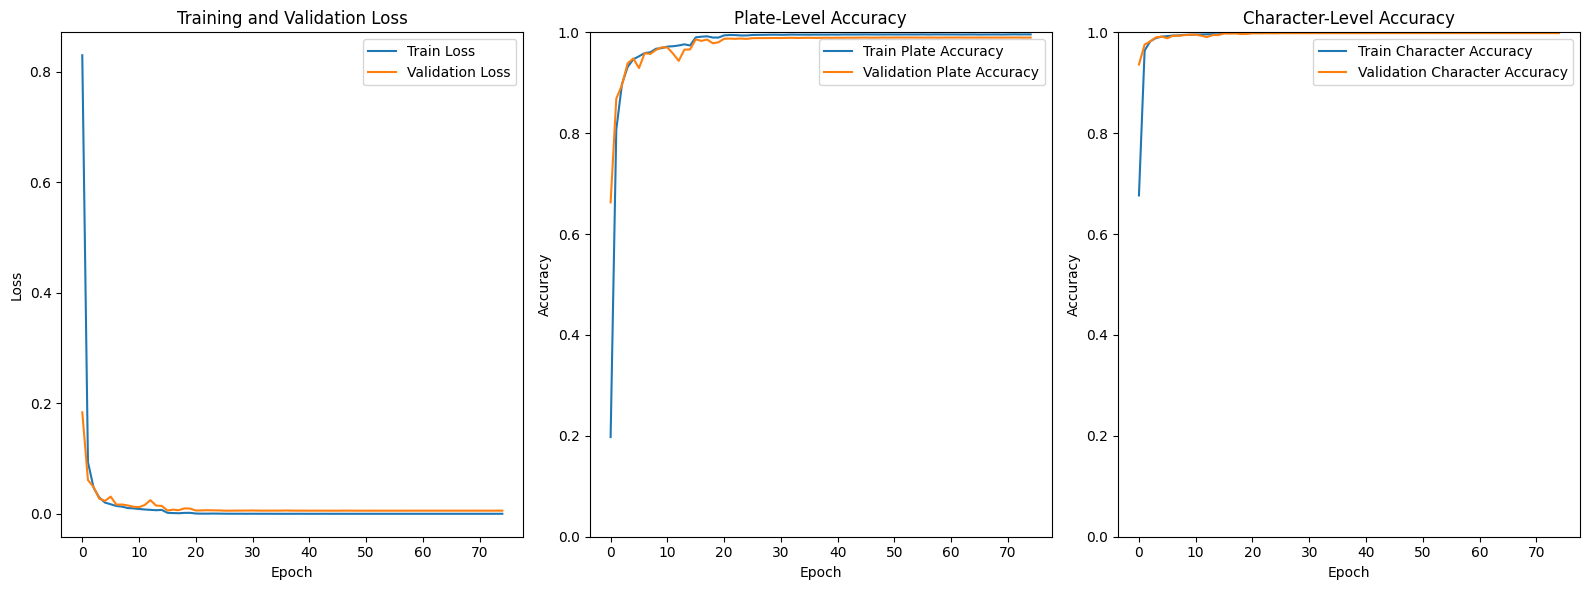

In [19]:
def plot_history_from_json(json_path):
    with open(json_path, 'r') as f:
        history = json.load(f)

    epochs = list(range(0, history['epoch']))

    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_plate_acc = history['train_plate_acc']
    val_plate_acc = history['val_plate_acc']
    train_char_acc = history['train_char_acc']
    val_char_acc = history['val_char_acc']

    plt.figure(figsize=(16, 6))

    # Plot delle loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle accuracies (targa)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_plate_acc, label='Train Plate Accuracy')
    plt.plot(epochs, val_plate_acc, label='Validation Plate Accuracy')
    plt.title('Plate-Level Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    # Plot delle accuracies (carattere)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_char_acc, label='Train Character Accuracy')
    plt.plot(epochs, val_char_acc, label='Validation Character Accuracy')
    plt.title('Character-Level Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history_from_json('checkpoints/training_history.json')


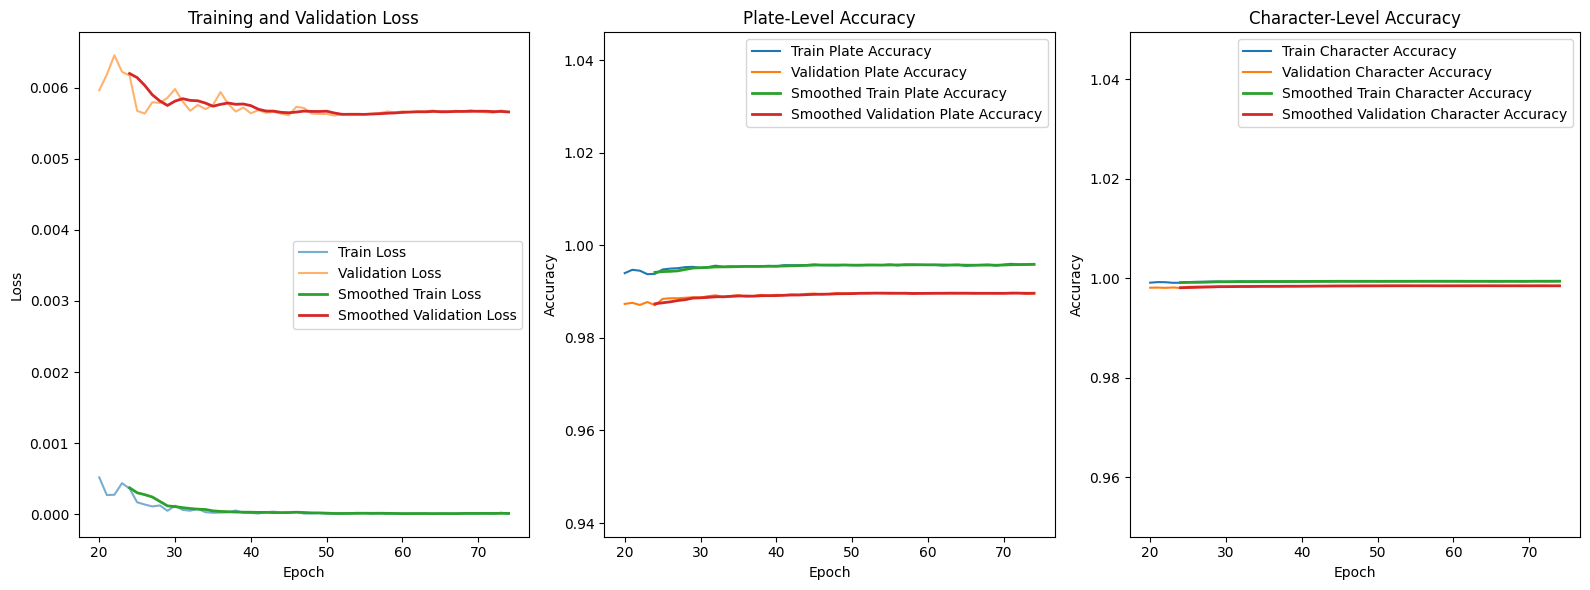

In [20]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_history_limited_from_json(json_path, max_epoch=75, last_n_epochs=None, smoothing_window=5):
    with open(json_path, 'r') as f:
        history = json.load(f)

    total_epochs = history['epoch']

    # Grafico limitato alle ultime N epoche
    if last_n_epochs:
        start_epoch = max_epoch - last_n_epochs
    else:
        start_epoch = 0

    end_epoch = max_epoch

    epochs = list(range(start_epoch, end_epoch))
    train_loss = history['train_loss'][start_epoch:end_epoch]
    val_loss = history['val_loss'][start_epoch:end_epoch]
    train_plate_acc = history['train_plate_acc'][start_epoch:end_epoch]
    val_plate_acc = history['val_plate_acc'][start_epoch:end_epoch]
    train_char_acc = history['train_char_acc'][start_epoch:end_epoch]
    val_char_acc = history['val_char_acc'][start_epoch:end_epoch]

    # Applicazione della media mobile (smoothed curve) alla loss
    smoothed_train_loss = moving_average(train_loss, smoothing_window)
    smoothed_val_loss = moving_average(val_loss, smoothing_window)

    # Applicazione della media mobile anche alle accuratezze
    smoothed_train_plate_acc = moving_average(train_plate_acc, smoothing_window)
    smoothed_val_plate_acc = moving_average(val_plate_acc, smoothing_window)
    smoothed_train_char_acc = moving_average(train_char_acc, smoothing_window)
    smoothed_val_char_acc = moving_average(val_char_acc, smoothing_window)

    plt.figure(figsize=(16, 6))

    # Plot delle loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss', alpha=0.6)
    plt.plot(epochs, val_loss, label='Validation Loss', alpha=0.6)
    plt.plot(epochs[smoothing_window-1:], smoothed_train_loss, label='Smoothed Train Loss', linewidth=2)
    plt.plot(epochs[smoothing_window-1:], smoothed_val_loss, label='Smoothed Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle accuracies (targa)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_plate_acc, label='Train Plate Accuracy')
    plt.plot(epochs, val_plate_acc, label='Validation Plate Accuracy')
    plt.plot(epochs[smoothing_window-1:], smoothed_train_plate_acc, label='Smoothed Train Plate Accuracy', linewidth=2)
    plt.plot(epochs[smoothing_window-1:], smoothed_val_plate_acc, label='Smoothed Validation Plate Accuracy', linewidth=2)
    plt.title('Plate-Level Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(min(min(train_plate_acc), min(val_plate_acc)) - 0.05, max(max(train_plate_acc), max(val_plate_acc)) + 0.05)
    plt.legend()

    # Plot delle accuracies (carattere)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_char_acc, label='Train Character Accuracy')
    plt.plot(epochs, val_char_acc, label='Validation Character Accuracy')
    plt.plot(epochs[smoothing_window-1:], smoothed_train_char_acc, label='Smoothed Train Character Accuracy', linewidth=2)
    plt.plot(epochs[smoothing_window-1:], smoothed_val_char_acc, label='Smoothed Validation Character Accuracy', linewidth=2)
    plt.title('Character-Level Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(min(min(train_char_acc), min(val_char_acc)) - 0.05, max(max(train_char_acc), max(val_char_acc)) + 0.05)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history_limited_from_json('checkpoints/training_history.json', max_epoch=75, last_n_epochs=55, smoothing_window=5)


In [21]:
# Funzione per trovare il miglior checkpoint in base alla validation loss

def find_best_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
    
    if not checkpoint_files:
        raise FileNotFoundError(f"Nessun checkpoint trovato in {checkpoint_dir}")
    
    best_acc = 0
    best_checkpoint = None
    
    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(checkpoint_file, map_location=device)
        
        if 'history' in checkpoint and 'val_plate_acc' in checkpoint['history']:
            max_acc = max(checkpoint['history']['val_plate_acc'])
            if max_acc > best_acc:
                best_acc = max_acc
                best_checkpoint = checkpoint_file
    
    if best_checkpoint is None:
        best_checkpoint = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
        print(f"Nessuna plate accuracy nei checkpoint. Si sceglie l'ultimo: {best_checkpoint}")
    else:
        print(f"Trovato miglior checkpoint (val_plate_acc={best_acc:.4f}): {best_checkpoint}")

    return best_checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint_dir = 'checkpoints'
best_checkpoint = find_best_checkpoint(checkpoint_dir)

trainer.load_checkpoint(best_checkpoint)

Trovato miglior checkpoint (val_plate_acc=0.9897): checkpoints/checkpoint_epoch_75.pth
Loaded checkpoint from epoch 75


75

Esecuzione del test sul file: ccpd_blur.csv


Validation: 100%|██████████| 4123/4123 [00:46<00:00, 88.81it/s]


Test Plate Accuracy: 0.5432
Test Character Accuracy: 0.8861
FPS: 443.89
Visualizzazione delle predizioni (3 immagini)


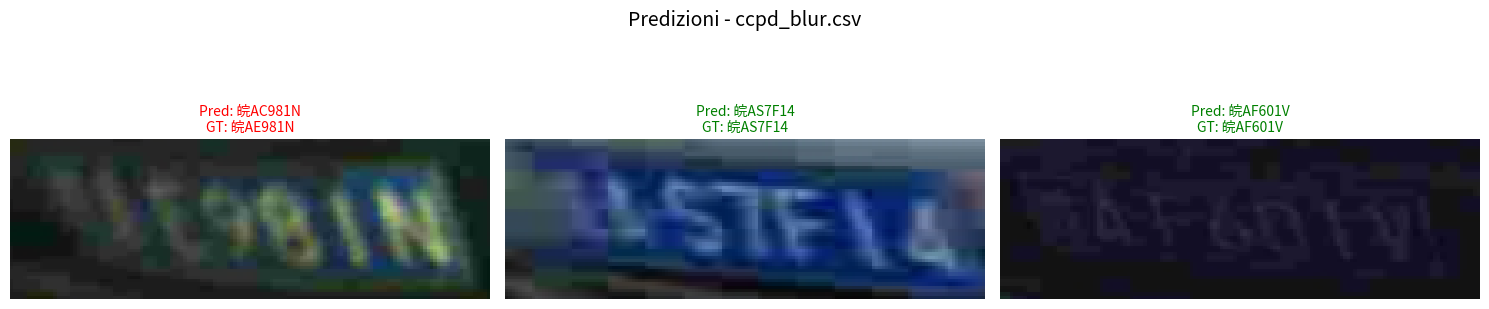

Esecuzione del test sul file: ccpd_challenge.csv


Validation: 100%|██████████| 10001/10001 [01:58<00:00, 84.72it/s]


Test Plate Accuracy: 0.6416
Test Character Accuracy: 0.9166
FPS: 423.59
Visualizzazione delle predizioni (3 immagini)


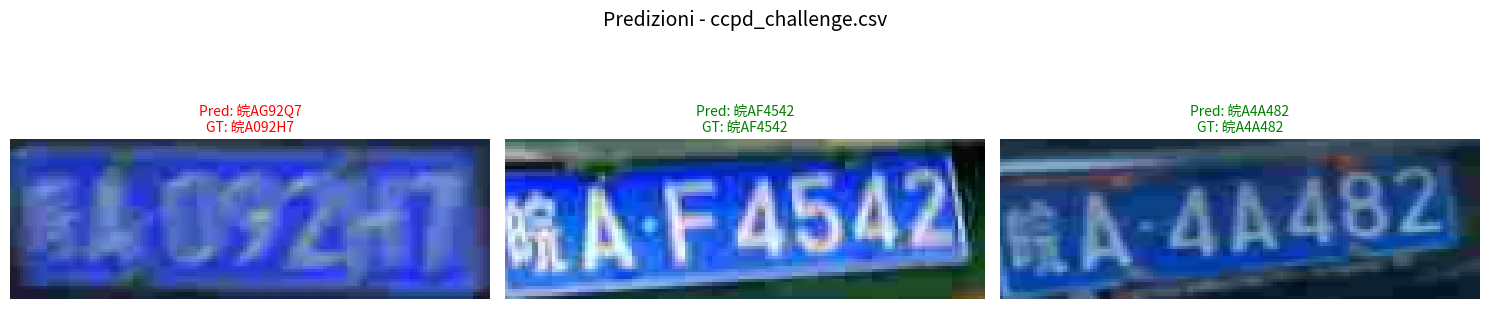

Esecuzione del test sul file: ccpd_db.csv


Validation: 100%|██████████| 2027/2027 [00:25<00:00, 79.67it/s]


Test Plate Accuracy: 0.5638
Test Character Accuracy: 0.8940
FPS: 398.11
Visualizzazione delle predizioni (3 immagini)


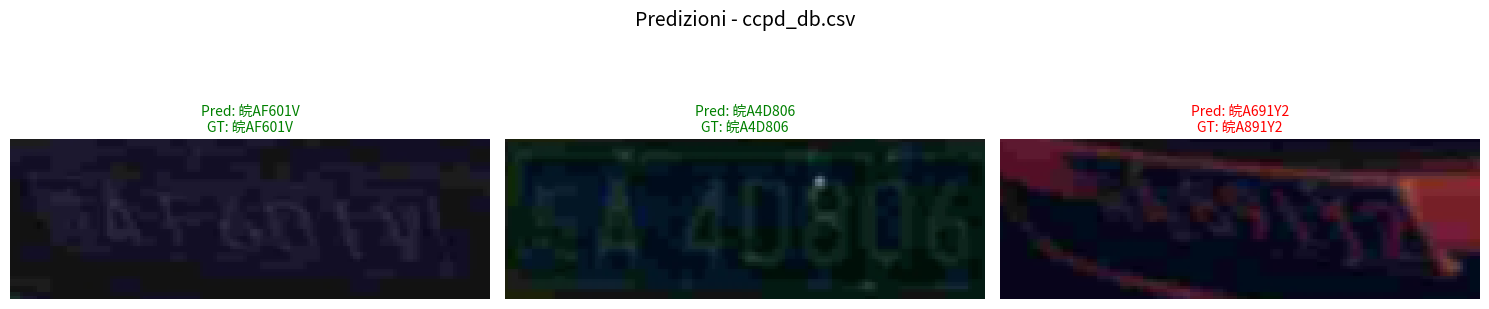

Esecuzione del test sul file: ccpd_fn.csv


Validation: 100%|██████████| 4194/4194 [00:50<00:00, 82.81it/s]


Test Plate Accuracy: 0.6063
Test Character Accuracy: 0.8895
FPS: 413.93
Visualizzazione delle predizioni (3 immagini)


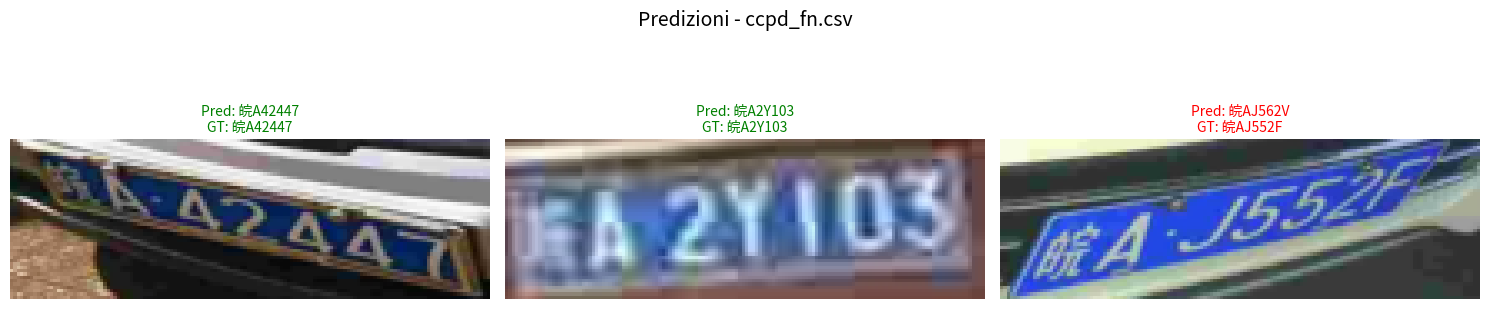

Esecuzione del test sul file: ccpd_rotate.csv


Validation: 100%|██████████| 2011/2011 [00:24<00:00, 82.16it/s]


Test Plate Accuracy: 0.5492
Test Character Accuracy: 0.8830
FPS: 410.61
Visualizzazione delle predizioni (3 immagini)


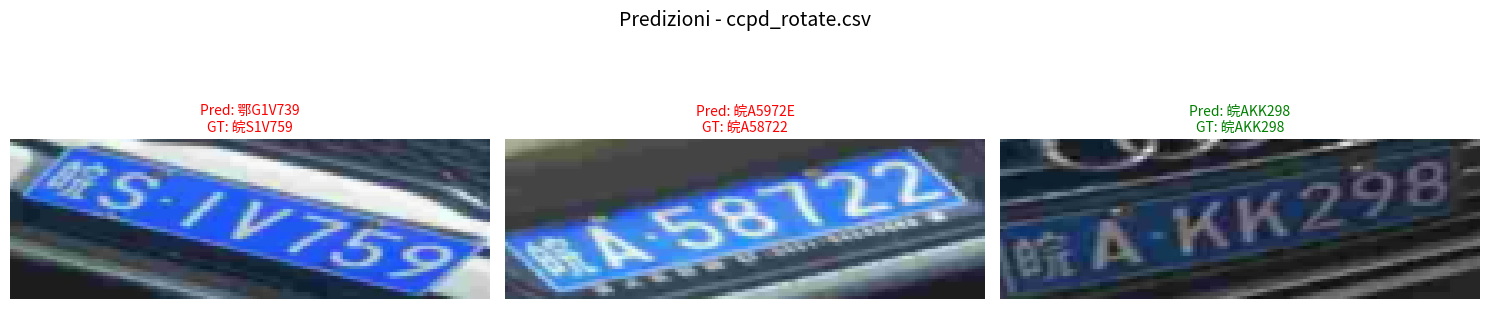

Esecuzione del test sul file: ccpd_tilt.csv


Validation: 100%|██████████| 6044/6044 [01:14<00:00, 81.42it/s]


Test Plate Accuracy: 0.4174
Test Character Accuracy: 0.8333
FPS: 407.00
Visualizzazione delle predizioni (3 immagini)


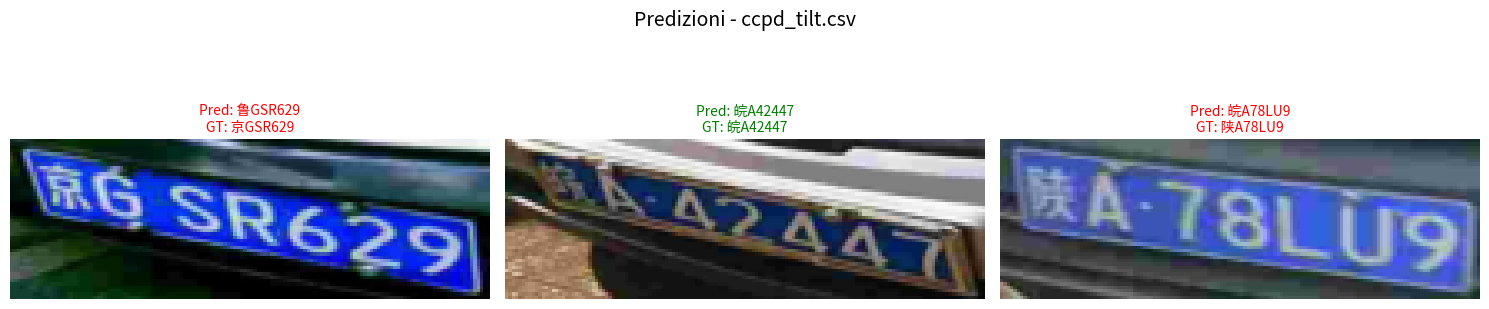

Esecuzione del test sul file: ccpd_weather.csv


Validation: 100%|██████████| 2000/2000 [00:24<00:00, 80.54it/s]


Test Plate Accuracy: 0.9732
Test Character Accuracy: 0.9958
FPS: 402.57
Visualizzazione delle predizioni (3 immagini)


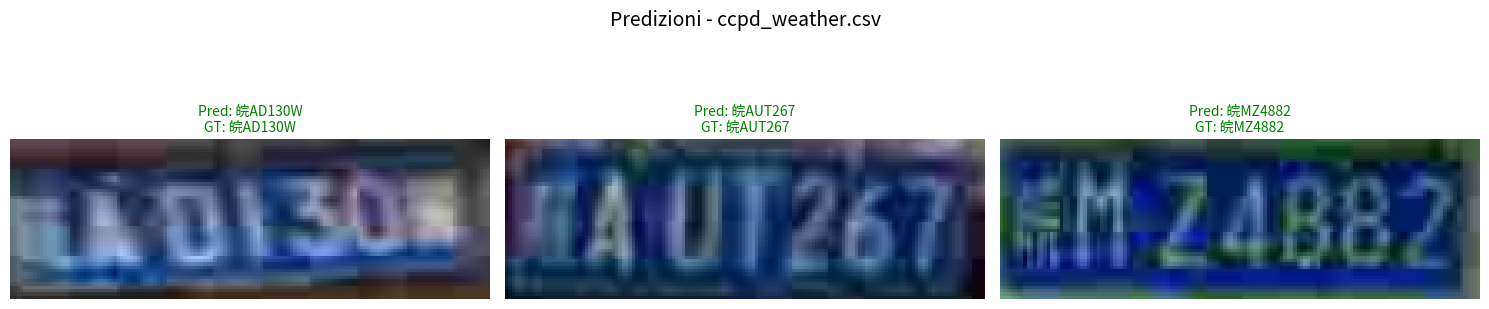


FPS medio sull'intero test: 414.24


In [24]:
# Font cinese
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' 
font_prop = fm.FontProperties(fname=font_path)

csv_dir = "."  # Directory dei CSV
csv_files = [
    "ccpd_blur.csv",
    "ccpd_challenge.csv",
    "ccpd_db.csv",
    "ccpd_fn.csv",
    "ccpd_rotate.csv",
    "ccpd_tilt.csv",
    "ccpd_weather.csv"
]

fps_list = []

for csv_file in csv_files:
    print(f"Esecuzione del test sul file: {csv_file}")

    test_df = pd.read_csv(os.path.join(csv_dir, csv_file))

    # Configura dataset e loader
    test_dataset = CCPDPlateDataset(
        csv_file=os.path.join(csv_dir, csv_file),
        base_dir=data_path,
        transform=PlateTransform(size=(48, 144), crop_plate=True),
        augment=False,
        mode='test'
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=5,
        shuffle=False,
        num_workers=4
    )

    trainer.val_loader = test_loader

    start = time.time()
    test_loss, test_plate_acc, test_char_acc, sample_preds = trainer.validate()
    duration = time.time() - start

    fps = len(test_dataset) / duration
    fps_list.append(fps)

    print(f"Test Plate Accuracy: {test_plate_acc:.4f}")
    print(f"Test Character Accuracy: {test_char_acc:.4f}")
    print(f"FPS: {fps:.2f}")

    # Visualizzazione delle prime 3 immagini
    num_to_show = 3
    images, preds, gts = [], [], []

    for idx, (sample, pred, gt) in enumerate(sample_preds[:num_to_show]):
        row = test_df.iloc[idx]
        img_rel = row['image_path']
        bbox = ast.literal_eval(row['bbox'])
        img_file = os.path.join(data_path, img_rel)

        try:
            img = Image.open(img_file).convert("RGB")
            x1, y1, x2, y2 = bbox
            crop = img.crop((x1, y1, x2, y2))
            crop = crop.resize((144, 48), Image.BILINEAR)
            images.append(np.array(crop))
            preds.append(pred)
            gts.append(gt)
        except Exception as e:
            print(f"[Errore immagine] {img_file}: {e}")

    print("Visualizzazione delle predizioni (3 immagini)")
    fig, axes = plt.subplots(1, num_to_show, figsize=(5 * num_to_show, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        color = "green" if preds[i] == gts[i] else "red"
        ax.set_title(f"Pred: {preds[i]}\nGT: {gts[i]}",
                     fontsize=12, color=color, fontproperties=font_prop)

    plt.suptitle(f"Predizioni - {csv_file}", fontsize=14, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

# Media generale FPS
mean_fps = sum(fps_list) / len(fps_list)
print(f"\nFPS medio sull'intero test: {mean_fps:.2f}")
